

### 1. 데이터 불러오기

#### 1. 터미널

In [ ]:
#1) 데이터 확인
!ls -l ~/data

#2) 프로젝트 폴더 생성
! mkdir -p ~/aiffel/yoochoose

#3) 프로젝트 폴더로 데이터 폴더 링크 연결
! ln -s ~/data/* ~/aiffel/yoochoose/data

#### 2. 데이터 불러오기

In [1]:
import os
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data를 id와 시간 순서로 정렬
data.sort_values(['UserId', 'Time'], inplace=True)  

data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


1) SessionID 대신 UserID 존재  
  - 명확한 1회 세션의 SessionID를 포함하지 않고 있음  
  - UserID가 SessionID 역할을 해야 함  
  - UserID, SessionID 다른점  
    같은 id면 다른 시간이여도 (몇년의 차이가 있더라도) 하나의 취향으로 묶임  
    session은 같은 시간대 + 같은 id를 묶어준것  
  
  
2) Ratin  
  - 평점  
  - 직전에 봤던 영화가 맘에 들었는지 여부가 
    비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있음  
  - Rating이 낮은 데이터를 어떻게 처리할지 고민해봐야함  



3) Time   
  - UTC time 가 포함되어  
    1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

### 3. 데이터 전처리  
#### 1. 필요한 컬럼만 데이터에 존재 함  
  UserId, ItemId , Rating , Time  
  
  
#### 2. Time 시간순으로 정렬되어 있음  

#### 3. UserId, ItemId 컬럼 수 확인하기

In [2]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### 4. 각 유저 (UserId) 의 대략적인 클릭 데이터 살펴보기

In [3]:
#len() : 리스트 길이 알려줌, 중첩 리스트 경우, 가장 바깥 리스트 길이 알려줌  
#size() : 요소의 개수 알려줌. 3X4 배열의 사이즈= 12로 나옴

#user_length : 한 유저가 갖는 row의 개수
#해당 유저가 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

## 중앙값이 가지는 의미는?

In [4]:
#유저들이 남기는 리뷰 개수의 중앙값, 평균값
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [5]:
#유저들이 남기는 리뷰 개수의 최소값, 최대값
user_length.min(), user_length.max()

(20, 2314)

In [6]:
#유저들이 남기는 리뷰 개수의 백분율 구하기
#quantile: 오름차순 정렬시, 최소값0 최대값100으로 백분율로 나타낸 값
user_length.quantile(0.999)

1343.181000000005

* 유저들이 남기는 평균 리뷰 수 : 165 개  
* 99퍼= 대부분 유저들은 1343개의 리뷰를 남김  

In [7]:
#최대 클릭 데이터 갖는 유저 확인
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


* 같은 유저이긴 하지만 너무 다른 시간대까지 포함되어  
  같은유저 + 같은 시간대를 반영한 Session 정의를 해야함  
  -> SessionId

#### 5. SessionId 포함한 data 생성
너무 오류가 나서,, 우수노드 참고

##### 1) 인덱스 만들기
같은 UserId, Time 으로 인덱스 생성

In [8]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
#inplace=True : 메소드 실행 후 적용된 데이터 프레임으로 반환 
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


##### 2) 위에서 정의한 SessionID 컬럼 추가

In [9]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


#### 6. SessionId_length

##### 1) SessionId 의 대략적인 평가한 영화 개수 살펴보기

In [10]:
#len() : 리스트 길이 알려줌, 중첩 리스트 경우, 가장 바깥 리스트 길이 알려줌  
#size() : 요소의 개수 알려줌. 3X4 배열의 사이즈= 12로 나옴

#session_length : 같은 SessionId를 갖는 row의 개수
#하나의 세션이 몇개의 영화를 평가했는가에 대한 정보를 담고 있음  
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [11]:
#한 세션당 평가한 영화 개수의 중앙값, 평균 구하기
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [12]:
#한 세션당 평가한 영화 개수의 최소, 최대값 구하기
session_length.min(), session_length.max()

(1, 30)

In [13]:
#한 세션당 평가한 영화 개수의 백분율 구하기
#quantile: 오름차순 정렬시, 최소값0 최대값100으로 백분율로 나타낸 값
session_length.quantile(0.999)

10.0

* UserId를 한 세션으로 봤을 때와 달리  
  조금더 합리적인 데이터 결과가 확인됨  
  

* 한 SessionId 당 평가한 평균 영화 개수 : 2  
* 대부분(99%)은 10개 정도의 영화를 평가함  
  10개 초과 ~ 30개 (최대값) 이하는 이상치로 판단됨  

In [14]:
#영화평가 30개한 세션 확인
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


* 너무 같은 시간에 많은 리뷰를 남김  
  조작된 리뷰는 아닌가? 합리적인 소비행태인가에 대한 판단력 필요함  

##### 2) SessionId_length 분포 시각화

In [15]:
# 각 리뷰 개수에 해당되는 세션 비율 확인하기
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

# 99.76(대부분)이 9이하의 리뷰 개수를 가지고 있음

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

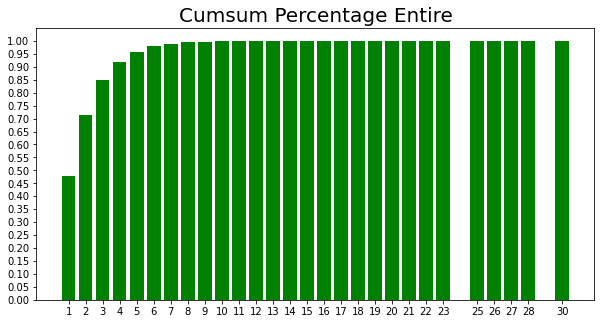

In [16]:
## 전체 분포 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='green')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Entire', size=20)
plt.show()

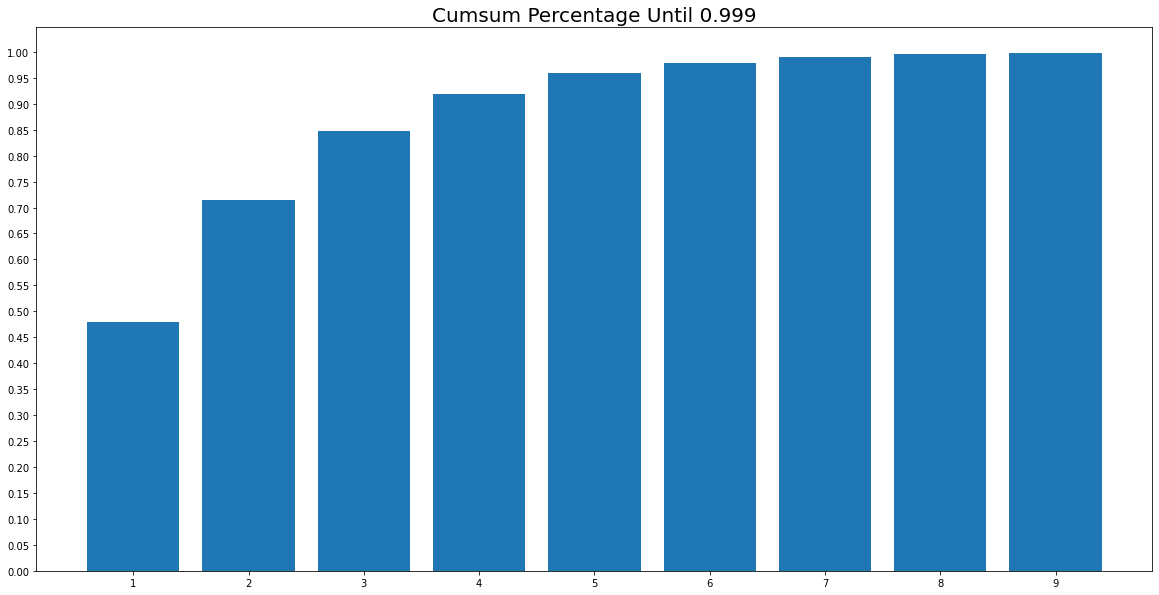

In [17]:
#9이하의 각 리뷰 개수에 해당되는 세션들의 분포 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### 7. Session Time
* 유저들의 소비 패턴은 금방 변함  
  -> 추천시스템을 구축할 때, **최근 소비 트렌드를 학습**하는 것이 중요  


* Q2. 추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있음  
  데이터 생성 날짜 말고 또 어떤 요소가 있을까?  
  
  접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일,  
  계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등

##### 1) Time 변환  : fromtimestamp()

In [18]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2


##### 2) 데이터의 시간 관련 정보를 확인

In [19]:
#가장 오래 전 리뷰 남긴 시간, 가장 최근 리뷰 남긴 시간 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


##### 3) 날짜끼리 비교(차이) 하기
* 약 3년치의 데이터가 있는데 최근 소비 트렌드 반영을 위해  
  각 년도 별 데이터수를 확인하고  
  최근 년도 데이터를 사용하는 것을 고려해본다  


* 한 세션당 남긴 평균 리뷰 개수 : 2 이고,  
  리뷰 1~4개까지 남긴 비율  : 91% 이다  
  때문에 그냥 모든 년도의 데이터를 반영하기로 함  

#### 8. Rating  
평점이 낮은 영화는 선호하는 영화라고 판단하기 어려움  
때문에 데이터를 제거하는것이 합리적으로 판단  

In [20]:
#1. 우선 각 평점에 대한 rating 개수를 구함  
print(len(data[data['Rating'] == 1]))   # 평점의 최솟값이 1이므로 Entire Data의 개수가 나온다.
print(len(data[data['Rating'] == 2]))   # 평점이 2점 이상인 데이터의 총 개수
print(len(data[data['Rating'] == 3]))   # 평점이 3점 이상인 데이터의 총 개수
print(len(data[data['Rating'] == 4]))   # 평점이 4점 이상인 데이터의 총 개수
print(len(data[data['Rating'] == 5]))   # 평점의 최댓값을 준 데이터의 개수이다.

56174
107557
261197
348971
226310


In [21]:
# 3~4점만 반영하기위해, data에서 1,2 점 리뷰 데이터는 삭제함
data = data[data['Rating'] >= 3]
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,2000-12-31 22:00:19,3186,4
1,1,1,2000-12-31 22:00:55,1270,5
2,1,1,2000-12-31 22:00:55,1721,4
3,1,1,2000-12-31 22:00:55,1022,5
4,2,1,2000-12-31 22:01:43,2340,3
...,...,...,...,...,...
1000204,471159,6040,2001-08-10 14:40:29,2917,4
1000205,471160,6040,2001-08-10 14:41:04,1921,4
1000206,471160,6040,2001-08-10 14:41:04,1784,3
1000207,471161,6040,2001-08-10 14:41:26,161,3


#### 9. SessionId_length 길이가 1인 경우 제거

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 
#다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

#shortest : shortest 번 만큼만 클릭한 세션(유저) 제거 
#least_click: least_click 번 만큼만 클릭되어진 아이템 제거
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
# 1번만 아이템 클릭한 세션아이디 제거
# 1번 이하만 클릭된 아이템 제거
data = cleanse_recursive(data, shortest=2, least_click=1)
data

,SessionId,UserId,Time,ItemId,Rating
1,1,1,2000-12-31 22:00:55,1270,5
2,1,1,2000-12-31 22:00:55,1721,4
3,1,1,2000-12-31 22:00:55,1022,5
7,5,1,2000-12-31 22:11:59,2804,5
8,5,1,2000-12-31 22:11:59,1207,4
...,...,...,...,...,...
1000189,471145,6040,2001-08-10 14:29:56,3362,4
1000190,471146,6040,2001-08-10 14:31:49,3421,3
1000191,471146,6040,2001-08-10 14:31:49,1258,4
1000205,471160,6040,2001-08-10 14:41:04,1921,4


### 4. train, val, test 분리  

* terain : val : test  
  = 8 : 1 :1  
  

* 3년의 1/10이 약 110 일  
  val, test를 110일로 설정하고  
  나머지는 train 데이터로 분리  

##### 1) n_days 전 후로 train, test 분리하는 함수 생성

In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

##### 2) 위 함수로 tr, val, test 분리하기

In [25]:
#n_days=110 일 전까지 tr, 후는 test
tr, test = split_by_date(data, n_days=110)

#분리된 tr 에서 n_days=110 일 전까지 tr, 후는 val
tr, val = split_by_date(tr, n_days=110)

##### 3) 분리된 데이터 확인하기

In [26]:
# data에 대한 정보를 살펴보는 함수 생성
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
#살펴보는 함수 호출
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

#의도대로 잘 나누어짐

#Events: 데이터 갯수
#Sessions: UserId의 고유값
#Items: ItemId의 고유값
#First Time : 최소시간
#Last Time : 최대시간

* train Set Stats Info
	 Events: 614604
	 Sessions: 204048
	 Items: 3527
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-07-22 13:56:03

* valid Set Stats Info
	 Events: 2088
	 Sessions: 794
	 Items: 1131
	 First Time : 2002-07-24 23:34:56
	 Last Time : 2002-11-10 08:45:55

* test Set Stats Info
	 Events: 2011
	 Sessions: 791
	 Items: 1098
	 First Time : 2002-11-10 21:01:17
	 Last Time : 2003-02-28 17:49:08



##### 4) train, val, test 모두에 있는 아이템만 사용하기

In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

#### 5) 전처리 + 분리 완료된 데이터 저장
데이터를 저장한 다음 나중에 data pipeline을 구축하려고 함

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 4. 미니배치 구현 _Data Pipeline  
이전 스텝에서 개념을 정리해 본 Session-Parallel Mini-Batch 구현

#### 1. SessionDataset

##### 1) 클래스 생성 : 각 세션마다 인덱스 값 부여
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과  
세션을 새로 인덱싱한 값을 갖는 클래스

In [30]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

##### 2) train데이터로 SessionDataset 객체 생성 -> 인스턴스 변수들 살펴봄  

In [31]:
# SessionDataset 객체 생성 
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,Time,ItemId,Rating,item_idx
1,1,1,2000-12-31 22:00:55,1270,5,0
2,1,1,2000-12-31 22:00:55,1721,4,1
3,1,1,2000-12-31 22:00:55,1022,5,2
7,5,1,2000-12-31 22:11:59,2804,5,3
8,5,1,2000-12-31 22:11:59,1207,4,4
9,6,1,2000-12-31 22:12:40,1193,5,5
10,6,1,2000-12-31 22:12:40,720,3,6
11,6,1,2000-12-31 22:12:40,260,4,7
19,14,1,2000-12-31 22:29:13,1035,5,8
20,14,1,2000-12-31 22:29:13,1962,4,9


In [32]:
#click_offsets : 각 세션이 시작된 인덱스를 담고 있음  
tr_dataset.click_offsets

array([     0,      3,      5, ..., 614600, 614602, 614604], dtype=int32)

In [33]:
#session_idx : 각 세션을 인덱싱한 np.array 
tr_dataset.session_idx

array([     0,      1,      2, ..., 204045, 204046, 204047])

#### 2. SessionDataLoader  
파이썬 문법 (iterator, generator) : https://dojang.io/mod/page/view.php?id=2405  

##### 1) Session-Parallel mini-batch 만드는 클래스 생성  

In [34]:
#SessionDataset 객체를 받아서 Session-Parallel mini-batch 만드는 클래스 생성 
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    # __iter__ 메소드 : 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """
        # mask : 후에 RNN Cell State를 초기화 하는데 사용
        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

##### 2) 위 클래스 사용하여 병렬구조 미니배치 생성

In [35]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,Time,ItemId,Rating,item_idx
1,1,1,2000-12-31 22:00:55,1270,5,0
2,1,1,2000-12-31 22:00:55,1721,4,1
3,1,1,2000-12-31 22:00:55,1022,5,2
7,5,1,2000-12-31 22:11:59,2804,5,3
8,5,1,2000-12-31 22:11:59,1207,4,4
9,6,1,2000-12-31 22:12:40,1193,5,5
10,6,1,2000-12-31 22:12:40,720,3,6
11,6,1,2000-12-31 22:12:40,260,4,7
19,14,1,2000-12-31 22:29:13,1035,5,8
20,14,1,2000-12-31 22:29:13,1962,4,9


In [36]:
iter_ex = iter(tr_data_loader)

In [37]:
#next : 계속 다음 데이터 생성 
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


### 5. 모델 생성  


In [38]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### 2. Model Architecture 구현

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [40]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [41]:
#하이퍼파라미터 관리 클래스 생성
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [42]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [43]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    536850    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


### 6. 모델 학습

#### 1. 모델 학습 함수 생성

In [44]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

#### 2. 함수 호출 및 학습 시작

In [45]:
train_model(model, args)

Train:   0%|          | 0/1603 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.03]

	 - Recall@20 epoch 1: 0.048828
	 - MRR@20    epoch 1: 0.009391



Train:   0%|          | 0/1603 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.44]

	 - Recall@20 epoch 2: 0.103516
	 - MRR@20    epoch 2: 0.030234



Train:   0%|          | 0/1603 [00:00<?, ?it/s, accuracy=0.043, train_loss=6.18] 

	 - Recall@20 epoch 3: 0.151367
	 - MRR@20    epoch 3: 0.046119



Train:   0%|          | 0/1603 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.09]

	 - Recall@20 epoch 4: 0.166016
	 - MRR@20    epoch 4: 0.052866



Evaluation:  80%|████████  | 4/5 [00:05<00:01,  1.44s/it]

	 - Recall@20 epoch 5: 0.174805
	 - MRR@20    epoch 5: 0.057009



### 7. 모델 테스트 
* 모델 성능 평가 지표 : precision, recall  
  - Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시  
    -> 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋음  
  - 이 때문에 recall의 개념을 확장한 **recall@k** 지표  
    (recall= 재현율= 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율)  
    precision의 개념을 확장한 **Mean Average Precision@k** 지표 등을 사용  



* 취향 적중된 추천에 대한 순서도 중요  
    - 순서에 민감한 지표 : **MRR, NDCG** 같은 지표도 사용  
    - MRR : 정답 아이템이 나온 순번의 역수 값 = 평균 상호 순위  
      (정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아짐  
      뒤쪽에 나오거나 안나온다면 지표가 낮아짐) 


* 사용할 평가 지표   
  **MRR, Recall@k**  
 
NDCG, MRR, MAP에 대한 자세한 설명  
(https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832) 

In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

	 - Recall@20: 0.181641
	 - MRR@20: 0.063126



### 8. 모델 성능 개선 _ 하이퍼파라미터 조정

#### 1. Batch size 변경

In [47]:
#1 batch_size=1024
args = Args(tr, val, test, batch_size=1024, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)


#배치 사이즈 크면 에러남 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1024, 1, 3527)]         0         
_________________________________________________________________
GRU (GRU)                    [(1024, 50), (1024, 50)]  536850    
_________________________________________________________________
dropout_1 (Dropout)          (1024, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (1024, 3527)              179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [68]:
train_model(model, args) 
#배치 사이즈 크면 에러남 

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index 794 is out of bounds for axis 0 with size 794

In [88]:
#2. batch_size=128
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)

In [87]:
train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.38] 

	 - Recall@20 epoch 1: 0.178711
	 - MRR@20    epoch 1: 0.057978



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.27] 

	 - Recall@20 epoch 2: 0.180664
	 - MRR@20    epoch 2: 0.056033



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.28] 

	 - Recall@20 epoch 3: 0.191406
	 - MRR@20    epoch 3: 0.058018



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.23] 

	 - Recall@20 epoch 4: 0.183594
	 - MRR@20    epoch 4: 0.055842



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6]    

	 - Recall@20 epoch 5: 0.182617
	 - MRR@20    epoch 5: 0.056478



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.07]

	 - Recall@20 epoch 6: 0.181641
	 - MRR@20    epoch 6: 0.055826



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.16]

	 - Recall@20 epoch 7: 0.169922
	 - MRR@20    epoch 7: 0.054798



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.15]

	 - Recall@20 epoch 8: 0.177734
	 - MRR@20    epoch 8: 0.055304



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.07]

	 - Recall@20 epoch 9: 0.166992
	 - MRR@20    epoch 9: 0.054715



Evaluation:  80%|████████  | 8/10 [00:05<00:01,  1.37it/s]

	 - Recall@20 epoch 10: 0.173828
	 - MRR@20    epoch 10: 0.056275



In [89]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.39it/s]

	 - Recall@20: 0.195312
	 - MRR@20: 0.068286



In [90]:
#3. batch_size= 64
args = Args(tr, val, test, batch_size= 64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(64, 1, 3527)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      536850    
_________________________________________________________________
dropout_14 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_14 (Dense)             (64, 3527)                179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [91]:
train_model(model, args)

Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.61]

	 - Recall@20 epoch 1: 0.120888
	 - MRR@20    epoch 1: 0.033978



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.95] 

	 - Recall@20 epoch 2: 0.198191
	 - MRR@20    epoch 2: 0.059895



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.05]

	 - Recall@20 epoch 3: 0.208882
	 - MRR@20    epoch 3: 0.070062



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.88]

	 - Recall@20 epoch 4: 0.210526
	 - MRR@20    epoch 4: 0.068132



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.8] 

	 - Recall@20 epoch 5: 0.210526
	 - MRR@20    epoch 5: 0.068893



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.86]

	 - Recall@20 epoch 6: 0.209704
	 - MRR@20    epoch 6: 0.070815



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.73]

	 - Recall@20 epoch 7: 0.209704
	 - MRR@20    epoch 7: 0.071483



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.58]

	 - Recall@20 epoch 8: 0.216283
	 - MRR@20    epoch 8: 0.070100



Train:   0%|          | 0/6414 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.6] 

	 - Recall@20 epoch 9: 0.215461
	 - MRR@20    epoch 9: 0.072145



Evaluation:  95%|█████████▌| 19/20 [00:07<00:00,  2.63it/s]

	 - Recall@20 epoch 10: 0.219572
	 - MRR@20    epoch 10: 0.073340



In [92]:
test_model(model, args, test)

Evaluation:  95%|█████████▍| 18/19 [00:06<00:00,  2.75it/s]

	 - Recall@20: 0.258681
	 - MRR@20: 0.097276



#### 2. epoch 변경

In [59]:
#1 epochs=10
args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    536850    
_________________________________________________________________
dropout_6 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (128, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [60]:
train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.87] 

	 - Recall@20 epoch 1: 0.083008
	 - MRR@20    epoch 1: 0.021416



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.11]

	 - Recall@20 epoch 2: 0.173828
	 - MRR@20    epoch 2: 0.048894



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.03]

	 - Recall@20 epoch 3: 0.193359
	 - MRR@20    epoch 3: 0.058371



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.95]

	 - Recall@20 epoch 4: 0.204102
	 - MRR@20    epoch 4: 0.065513



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.86] 

	 - Recall@20 epoch 5: 0.212891
	 - MRR@20    epoch 5: 0.068447



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.79]

	 - Recall@20 epoch 6: 0.217773
	 - MRR@20    epoch 6: 0.069808



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.47] 

	 - Recall@20 epoch 7: 0.216797
	 - MRR@20    epoch 7: 0.069277



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.73] 

	 - Recall@20 epoch 8: 0.217773
	 - MRR@20    epoch 8: 0.068882



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.46] 

	 - Recall@20 epoch 9: 0.221680
	 - MRR@20    epoch 9: 0.067562



Evaluation:  80%|████████  | 8/10 [00:05<00:01,  1.38it/s]

	 - Recall@20 epoch 10: 0.224609
	 - MRR@20    epoch 10: 0.068598



In [61]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.42it/s]

	 - Recall@20: 0.237305
	 - MRR@20: 0.088246



In [62]:
#2 epochs= 15
args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(128, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    536850    
_________________________________________________________________
dropout_7 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_7 (Dense)              (128, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [63]:
train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.85] 

	 - Recall@20 epoch 1: 0.092773
	 - MRR@20    epoch 1: 0.024890



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.04]

	 - Recall@20 epoch 2: 0.175781
	 - MRR@20    epoch 2: 0.049671



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.09]

	 - Recall@20 epoch 3: 0.200195
	 - MRR@20    epoch 3: 0.064102



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.05] 

	 - Recall@20 epoch 4: 0.213867
	 - MRR@20    epoch 4: 0.070785



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.93]

	 - Recall@20 epoch 5: 0.220703
	 - MRR@20    epoch 5: 0.073110



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.46]

	 - Recall@20 epoch 6: 0.218750
	 - MRR@20    epoch 6: 0.072599



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.91]

	 - Recall@20 epoch 7: 0.213867
	 - MRR@20    epoch 7: 0.074712



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.75] 

	 - Recall@20 epoch 8: 0.215820
	 - MRR@20    epoch 8: 0.074567



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.81] 

	 - Recall@20 epoch 9: 0.212891
	 - MRR@20    epoch 9: 0.073014



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.75] 

	 - Recall@20 epoch 10: 0.210938
	 - MRR@20    epoch 10: 0.073482



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.75]

	 - Recall@20 epoch 11: 0.207031
	 - MRR@20    epoch 11: 0.071416



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.66] 

	 - Recall@20 epoch 12: 0.210938
	 - MRR@20    epoch 12: 0.071542



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.61] 

	 - Recall@20 epoch 13: 0.209961
	 - MRR@20    epoch 13: 0.070288



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.69] 

	 - Recall@20 epoch 14: 0.208008
	 - MRR@20    epoch 14: 0.070836



Evaluation:  80%|████████  | 8/10 [00:05<00:01,  1.38it/s]

	 - Recall@20 epoch 15: 0.208984
	 - MRR@20    epoch 15: 0.067960



In [64]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.42it/s]

	 - Recall@20: 0.234375
	 - MRR@20: 0.089609



In [65]:
#3 epochs=20
args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(128, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    536850    
_________________________________________________________________
dropout_8 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_8 (Dense)              (128, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [66]:
train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.9]  

	 - Recall@20 epoch 1: 0.093750
	 - MRR@20    epoch 1: 0.022537



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.2]  

	 - Recall@20 epoch 2: 0.176758
	 - MRR@20    epoch 2: 0.050703



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.01]

	 - Recall@20 epoch 3: 0.209961
	 - MRR@20    epoch 3: 0.067209



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.95] 

	 - Recall@20 epoch 4: 0.221680
	 - MRR@20    epoch 4: 0.069520



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.91]

	 - Recall@20 epoch 5: 0.221680
	 - MRR@20    epoch 5: 0.071602



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.74] 

	 - Recall@20 epoch 6: 0.222656
	 - MRR@20    epoch 6: 0.069359



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.69] 

	 - Recall@20 epoch 7: 0.221680
	 - MRR@20    epoch 7: 0.070350



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.71] 

	 - Recall@20 epoch 8: 0.216797
	 - MRR@20    epoch 8: 0.070311



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.74] 

	 - Recall@20 epoch 9: 0.214844
	 - MRR@20    epoch 9: 0.071196



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.59]

	 - Recall@20 epoch 10: 0.213867
	 - MRR@20    epoch 10: 0.070783



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.61]  

	 - Recall@20 epoch 11: 0.218750
	 - MRR@20    epoch 11: 0.070453



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.57] 

	 - Recall@20 epoch 12: 0.220703
	 - MRR@20    epoch 12: 0.070710



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.48]

	 - Recall@20 epoch 13: 0.217773
	 - MRR@20    epoch 13: 0.070983



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.59] 

	 - Recall@20 epoch 14: 0.219727
	 - MRR@20    epoch 14: 0.070158



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.48] 

	 - Recall@20 epoch 15: 0.212891
	 - MRR@20    epoch 15: 0.069979



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.49]

	 - Recall@20 epoch 16: 0.208008
	 - MRR@20    epoch 16: 0.069062



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.45] 

	 - Recall@20 epoch 17: 0.212891
	 - MRR@20    epoch 17: 0.069097



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.33]

	 - Recall@20 epoch 18: 0.209961
	 - MRR@20    epoch 18: 0.069133



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.5]   

	 - Recall@20 epoch 19: 0.208008
	 - MRR@20    epoch 19: 0.067363



Evaluation:  80%|████████  | 8/10 [00:05<00:01,  1.37it/s]

	 - Recall@20 epoch 20: 0.208984
	 - MRR@20    epoch 20: 0.067140



In [67]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.41it/s]

	 - Recall@20: 0.238281
	 - MRR@20: 0.080938



#### 3. droprate 변경

In [68]:
#1 drop_rate=0.2
args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(128, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    536850    
_________________________________________________________________
dropout_9 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_9 (Dense)              (128, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [69]:
hystory_d1=train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.88] 

	 - Recall@20 epoch 1: 0.083984
	 - MRR@20    epoch 1: 0.019311



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.33]

	 - Recall@20 epoch 2: 0.170898
	 - MRR@20    epoch 2: 0.050231



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=6.12] 

	 - Recall@20 epoch 3: 0.203125
	 - MRR@20    epoch 3: 0.061847



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.06]

	 - Recall@20 epoch 4: 0.215820
	 - MRR@20    epoch 4: 0.065706



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.96] 

	 - Recall@20 epoch 5: 0.219727
	 - MRR@20    epoch 5: 0.070657



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.95] 

	 - Recall@20 epoch 6: 0.219727
	 - MRR@20    epoch 6: 0.070657



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.78] 

	 - Recall@20 epoch 7: 0.218750
	 - MRR@20    epoch 7: 0.072032



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.85] 

	 - Recall@20 epoch 8: 0.213867
	 - MRR@20    epoch 8: 0.072114



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.77]

	 - Recall@20 epoch 9: 0.218750
	 - MRR@20    epoch 9: 0.071183



Evaluation:  80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

	 - Recall@20 epoch 10: 0.216797
	 - MRR@20    epoch 10: 0.073435



In [70]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.41it/s]

	 - Recall@20: 0.233398
	 - MRR@20: 0.084766



In [71]:
#2 drop_rate=0.5
args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(128, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    536850    
_________________________________________________________________
dropout_10 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_10 (Dense)             (128, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [72]:
hystory_d2=train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.08] 

	 - Recall@20 epoch 1: 0.073242
	 - MRR@20    epoch 1: 0.015948



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.62] 

	 - Recall@20 epoch 2: 0.139648
	 - MRR@20    epoch 2: 0.040045



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.25] 

	 - Recall@20 epoch 3: 0.184570
	 - MRR@20    epoch 3: 0.053705



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.38] 

	 - Recall@20 epoch 4: 0.199219
	 - MRR@20    epoch 4: 0.061705



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.09]

	 - Recall@20 epoch 5: 0.200195
	 - MRR@20    epoch 5: 0.065886



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.04] 

	 - Recall@20 epoch 6: 0.217773
	 - MRR@20    epoch 6: 0.068198



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.92] 

	 - Recall@20 epoch 7: 0.212891
	 - MRR@20    epoch 7: 0.068117



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.13] 

	 - Recall@20 epoch 8: 0.221680
	 - MRR@20    epoch 8: 0.069228



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.09]

	 - Recall@20 epoch 9: 0.221680
	 - MRR@20    epoch 9: 0.069821



Evaluation:  80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

	 - Recall@20 epoch 10: 0.219727
	 - MRR@20    epoch 10: 0.069245



In [73]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.40it/s]

	 - Recall@20: 0.234375
	 - MRR@20: 0.083033



In [74]:
#3 drop_rate=0.9
args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.9, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(128, 1, 3527)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    536850    
_________________________________________________________________
dropout_11 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_11 (Dense)             (128, 3527)               179877    
Total params: 716,727
Trainable params: 716,727
Non-trainable params: 0
_________________________________________________________________


In [75]:
hystory_d3=train_model(model, args)

Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.29] 

	 - Recall@20 epoch 1: 0.050781
	 - MRR@20    epoch 1: 0.010666



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.15]

	 - Recall@20 epoch 2: 0.058594
	 - MRR@20    epoch 2: 0.012714



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7]    

	 - Recall@20 epoch 3: 0.069336
	 - MRR@20    epoch 3: 0.015127



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.91] 

	 - Recall@20 epoch 4: 0.090820
	 - MRR@20    epoch 4: 0.022429



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.9]  

	 - Recall@20 epoch 5: 0.114258
	 - MRR@20    epoch 5: 0.028585



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.92] 

	 - Recall@20 epoch 6: 0.126953
	 - MRR@20    epoch 6: 0.032156



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.84] 

	 - Recall@20 epoch 7: 0.129883
	 - MRR@20    epoch 7: 0.035541



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.7] 

	 - Recall@20 epoch 8: 0.131836
	 - MRR@20    epoch 8: 0.038768



Train:   0%|          | 0/3207 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.63] 

	 - Recall@20 epoch 9: 0.147461
	 - MRR@20    epoch 9: 0.040363



Evaluation:  80%|████████  | 8/10 [00:06<00:01,  1.32it/s]

	 - Recall@20 epoch 10: 0.155273
	 - MRR@20    epoch 10: 0.043417



In [76]:
test_model(model, args, test)

Evaluation:  89%|████████▉ | 8/9 [00:05<00:00,  1.34it/s]

	 - Recall@20: 0.156250
	 - MRR@20: 0.049881



### 9. 시각화

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'recall', 'MRR@20']):
    ax[i].plot(history_d3.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

### 회고  

#### 💚루브릭  
**1.** Movielens 데이터셋을 session based recommendation 관점으로 체계적인 전처리 진행  
  * 새로운 SessionID 컬럼 생성  
    같은 UserId면 다른 시간이여도 (몇년의 차이가 있더라도) 하나의 취향으로 묶여버림  
    -> 그래서 session은 같은 시간대 + 같은 id를 묶어준것  
  
  
  * 한 세션당 남긴 평균 리뷰 개수 : 2  
      리뷰 1~4개까지 남긴 비율 : 91%  
      -> 그래서 그냥 모든 시간대의 데이터 반영하기로 함 (3년 길이의 시간)  


**2.** RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행됨  
  * train loss가 안정적으로 감소   
  * validation 단계에서의 Recall, MRR이 개선됨  
  
  
  * 모델 스펙 : args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

|    |train | test |
|---|---|---|
|Recall@20|0.174805| 0.181641|
|MRR@20|0.057009| 0.063126|


**3.** 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
1. batchsize  
  * 모델 스펙 : args = Args(tr, val, test, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
  * batchsize= 256 모델만 에포크 : 5
  
|    |batchsize=64 | batchsize=128 | batchsize= 256 |
|---|---|---|---|
|Recall@20| 0.258681 | 0.195312|  0.181641|
|MRR@20| 0.097276| 0.068286 |  0.057009 |

* 인사이트 : batchsize=64 때가 가장 성능 좋음  

2. epoch  
  * 모델 스펙 : args = Args(tr, val, test, batch_size= 128, hsz=50, drop_rate=0.1, lr=0.001, k=20)  
  * 변경전 : epoch =1  
  
|    |epoch =10 | epoch =15 | epoch =20 |
|---|---|---|---|
|Recall@20|0.237305   |0.234375   |0.238281|
|MRR@20|0.088246|  0.089609 |0.080938 |  

* 인사이트 : 에포크 값이 그렇게 큰 영향 못주는 것 같음  


3. droprate를 변경해가면서 실험함  
  * 모델 스펙 : args = Args(tr, val, test, batch_size= 128, hsz=50, lr=0.001, epochs=10, k=20)  
  * 변경전엔 droprate =0.1  
  
|    |drop_rate=0.2 | drop_rate=0.5 | drop_rate=0.9 |
|---|---|---|---|
|Recall@20|0.233398   | 0.234375   |0.156250|
|MRR@20|0.084766| 0.083033 |0.049881|  

* 인사이트 : dropout=0.9가 가장 낮은 성능을 보임, 앞의 모델이 과적합은 아니었던것 같음 

#### 💚어려웠던 점  
데이터셋에 대한 이해도가 낮기 때문일까  
SessionId 에 대한 정의를 스스로 해볼때  
유도해내는 것에 대해서 아주 어려웠음  

#### 💚더 개선해볼 점  
- 학습 결과들에 대해서 시각화 도전 :  
  코드 에러는 안나는데 런타임이 너무 길어서 계속 컴퓨터가 꺼지거나  
  커널이 다운되어버림  
  왜 안되는지 이유에 대해서 알아봐야함  

- 구체적으로 어떤 영화가 추천되는지에 대해서 알아보는 것을 알아보고 싶다  
  (비슷하지 않은 결과를 더 얻을 수 있을리라도)  